In [48]:
# !pip install ta
# !pip install yfinance
# !pip install

In [49]:
# Data minipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import datetime
import math
from scipy.stats import zscore
from datetime import datetime
from zoneinfo import ZoneInfo
from backtrader.feeds import PandasData
import pyfolio as pf
import backtrader as bt

# Models
import pickle
from keras.models import load_model
# from google.colab import drive

# Feature creation
import yfinance as yf
import ta
from ta import add_all_ta_features
from ta import momentum
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.momentum import AwesomeOscillatorIndicator

# Tensorflow
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Dense
from tensorflow.keras import callbacks
# from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers.experimental import RMSprop
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import legacy
from tensorflow.random import set_seed
from numpy.random import seed
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.layers import Reshape

# Scikitlearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

In [50]:
def yf_download(tickers, years='30y'):
    ticker_dict = {}
    for ticker in tickers:
        df_ticker = yf.download(ticker,
                                period=years,
                                interval='1d',
                                ignore_tz=True,
                                prepost=False
                                )
        ticker_dict[ticker] = df_ticker
    return ticker_dict

In [51]:
bench_target = '^SPX'
ticker_list = [bench_target, '^VIX', 'DX-Y.NYB', '^TNX', 'GC=F', 'CL=F', '^FVX', '^IRX']

ticker_dict = yf_download(ticker_list)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
# Create an empty DataFrame
all_df = pd.DataFrame(index=ticker_dict[bench_target].index)
ticker_start_date_list = []
ticker_end_date_list = []

# Iterate through the dictionary of stocks
for index, df_index in ticker_dict.items():
    # Create a prefix for column names with the stock symbol
    column_prefix = f'{index}_'

    # Add the stock data to the combined DataFrame with modified column names
    # all_df[column_prefix + 'Adj_Close'] = df_index['Adj Close']

    all_df[column_prefix + '50ma'] = df_index['Adj Close'].rolling(window=50).mean()
    all_df[column_prefix + '125ma'] = df_index['Adj Close'].rolling(window=125).mean()
    all_df[column_prefix + '125ma_50ma_delta'] = all_df[column_prefix + '125ma'] - all_df[column_prefix + '50ma']
    all_df[column_prefix + '50ma_delta'] = df_index['Adj Close'] - all_df[column_prefix + '50ma']
    all_df[column_prefix + '125ma_delta'] = df_index['Adj Close'] - all_df[column_prefix + '125ma']

    bb = BollingerBands(df_index['Adj Close'])
    all_df[column_prefix + 'bb_upper'] = bb.bollinger_hband()
    all_df[column_prefix + 'bb_lower'] = bb.bollinger_lband()
    all_df[column_prefix + 'bb_upper_delta'] = all_df[column_prefix + 'bb_upper'] - df_index['Adj Close']
    all_df[column_prefix + 'bb_lower_delta'] = df_index['Adj Close'] - all_df[column_prefix + 'bb_lower']

    macd = MACD(df_index['Adj Close'])
    all_df[column_prefix + 'macd'] = macd.macd()

    rsi = RSIIndicator(df_index['Adj Close'])
    all_df[column_prefix + 'rsi'] = rsi.rsi()

    # Calculate 1, 3, 6, and 12 month momentum using adjusted close
    all_df[column_prefix + 'momentum_1m'] = momentum.roc(df_index['Adj Close'], window=20)
    all_df[column_prefix + 'momentum_3m'] = momentum.roc(df_index['Adj Close'], window=60)
    all_df[column_prefix + 'momentum_6m'] = momentum.roc(df_index['Adj Close'], window=120)
    # all_df[column_prefix + 'momentum_12m'] = momentum.roc(df_index['Adj Close'], window=240)

    volume_zero = (df_index['Volume'] == 0).sum()
    volume_percentage = volume_zero / len(df_index['Volume'])
    if volume_percentage <= 0.95:
        obv = OnBalanceVolumeIndicator(df_index['Adj Close'], df_index['Volume'])
        all_df[column_prefix + 'obv'] = obv.on_balance_volume()
        all_df[column_prefix + 'obv_log_return'] = np.log(all_df[column_prefix + 'obv']/all_df[column_prefix + 'obv'].shift(1))

    awesome_oscillator = AwesomeOscillatorIndicator(df_index['Adj Close'], df_index['Low'])
    all_df[column_prefix + 'awesome_oscillator'] = awesome_oscillator.awesome_oscillator()

    # all_df[column_prefix + 'return'] = df_index['Adj Close'].pct_change()
    all_df[column_prefix + 'log_return'] = np.log(df_index['Adj Close']/df_index['Adj Close'].shift(1))

    all_df[column_prefix + '50ma_log_return'] = np.log(all_df[column_prefix + '50ma']/all_df[column_prefix + '50ma'].shift(1))
    all_df[column_prefix + '125ma_log_return'] = np.log(all_df[column_prefix + '125ma']/all_df[column_prefix + '125ma'].shift(1))
    all_df[column_prefix + '125ma_50ma_delta'] = np.log(all_df[column_prefix + '125ma_50ma_delta']/all_df[column_prefix + '125ma_50ma_delta'].shift(1))

    all_df[column_prefix + 'oc_delta'] = df_index['Open'] - df_index['Close']
    all_df[column_prefix + 'hl_delta'] = df_index['High'] - df_index['Low']


    ticker_start_date_list.append(df_index.index.min())
    ticker_end_date_list.append(df_index.index.max())

# Display the resulting DataFrame
all_df.columns = all_df.columns.str.lower()

start_date = max(ticker_start_date_list)
end_date = min(ticker_end_date_list)
print(start_date, end_date)
all_df = all_df[all_df.index >= start_date]
print(start_date, end_date)

2000-08-30 00:00:00 2023-06-30 00:00:00
2000-08-30 00:00:00 2023-06-30 00:00:00


/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarni

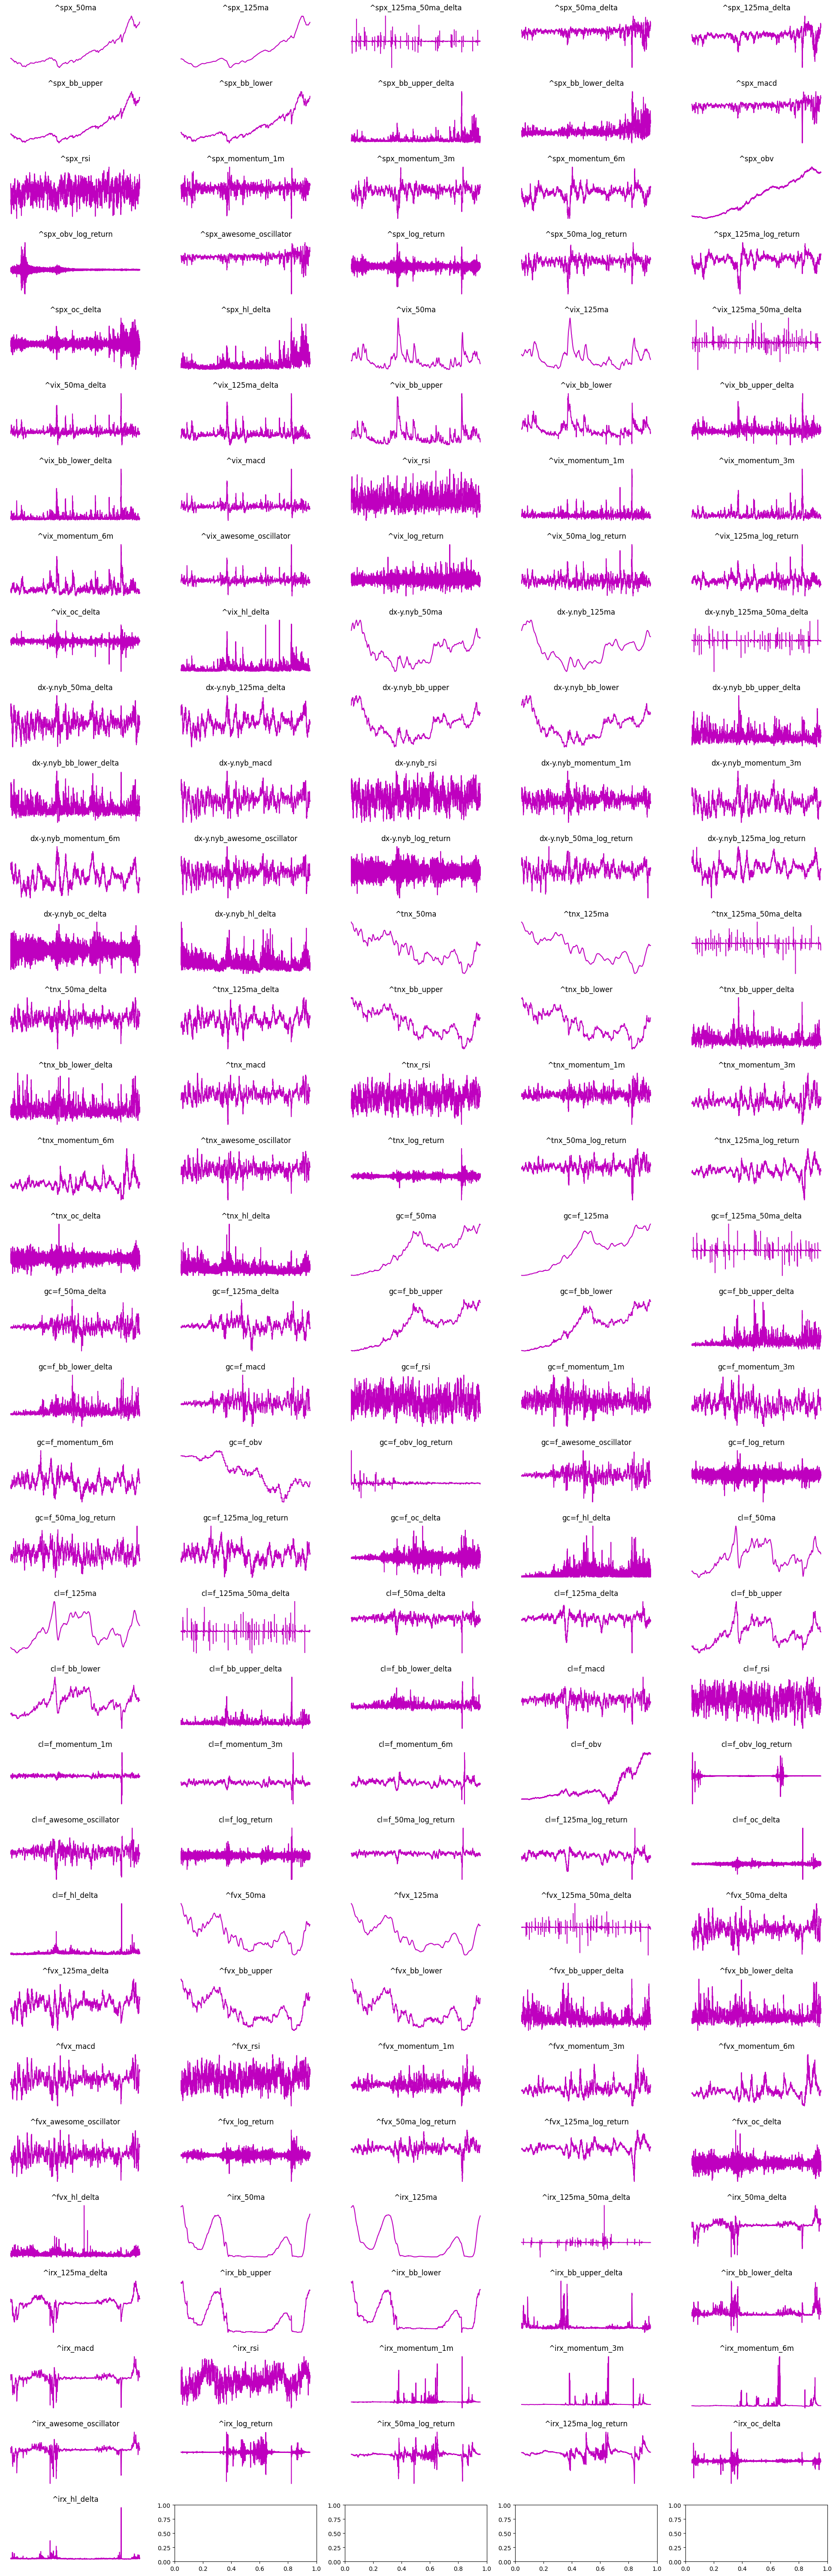

In [53]:
col_width = 5
col_count = all_df.shape[-1]
rows = math.ceil(col_count / col_width)

fig, ax = plt.subplots(rows, col_width, figsize=(20,60))
fig.tight_layout()
ax = ax.flatten()
for i, col in enumerate(all_df.columns):
    ax[i].plot(all_df[col], color="m")
    ax[i].title.set_text(col)
    ax[i].axis('off')
plt.show()

<Axes: xlabel='Date', ylabel='^spx_125ma_50ma_delta'>

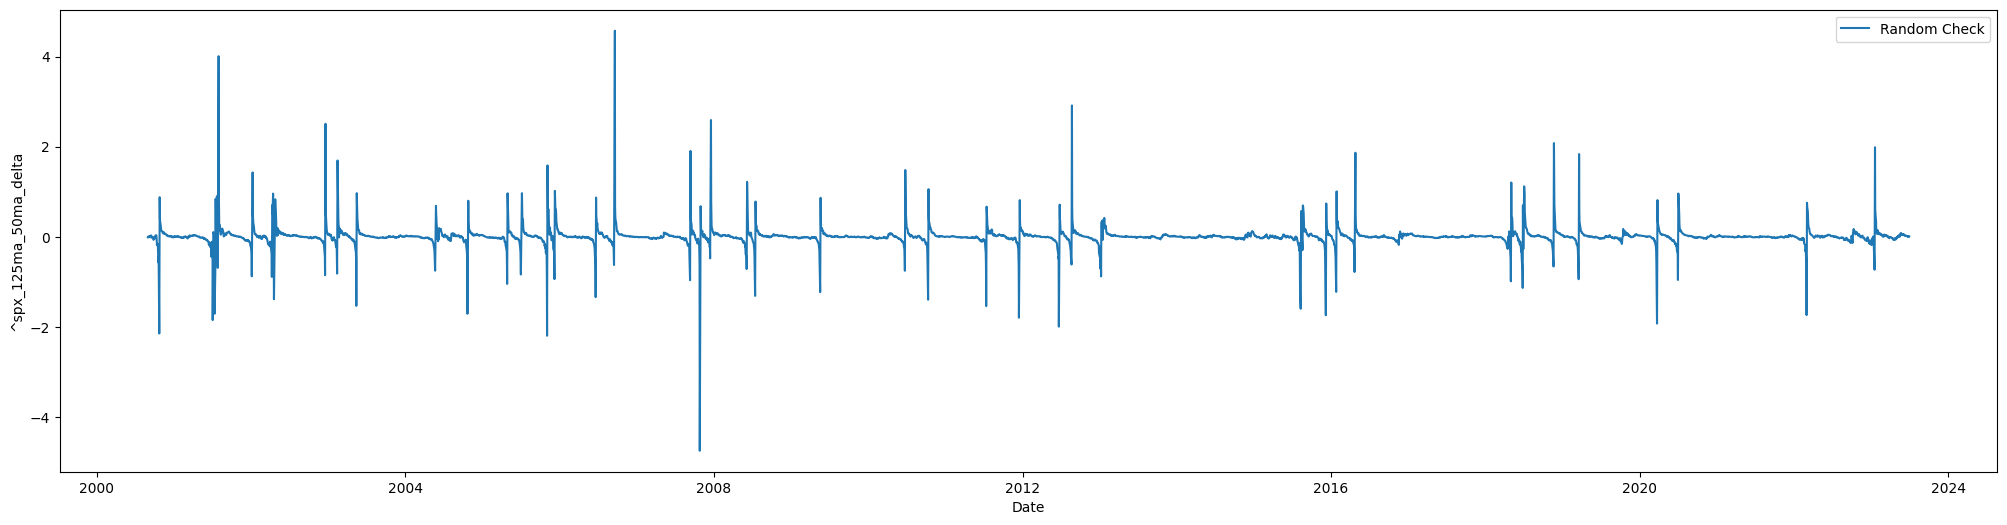

In [54]:
plt.figure(figsize=(25, 6))
sns.lineplot(data=all_df, x=all_df.index, y='^spx_125ma_50ma_delta', label='Random Check')

In [55]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5744 entries, 2000-08-30 to 2023-06-30
Columns: 166 entries, ^spx_50ma to ^irx_hl_delta
dtypes: float64(165), int64(1)
memory usage: 7.3 MB


In [56]:
# Calculate the threshold based on the percentage
threshold = len(all_df) * 0.975

# Drop columns with more NaN values than the threshold
all_df = all_df.dropna(axis=1, thresh=threshold, inplace=False)

all_df.isna().sum()

^spx_50ma                 0
^spx_125ma                0
^spx_125ma_50ma_delta    44
^spx_50ma_delta           0
^spx_125ma_delta          0
                         ..
^irx_log_return           9
^irx_50ma_log_return     14
^irx_125ma_log_return    14
^irx_oc_delta             7
^irx_hl_delta             7
Length: 162, dtype: int64

In [57]:
# Once confirming why there are NAs, proceed to drop
X_data = all_df.dropna(axis=0, inplace=False)
X_data.isna().sum()

^spx_50ma                0
^spx_125ma               0
^spx_125ma_50ma_delta    0
^spx_50ma_delta          0
^spx_125ma_delta         0
                        ..
^irx_log_return          0
^irx_50ma_log_return     0
^irx_125ma_log_return    0
^irx_oc_delta            0
^irx_hl_delta            0
Length: 162, dtype: int64

In [58]:
input_steps = 60
return_days = 10
# steps = 60 -> current winner
# days = 10 -> current winner

index_df = ticker_dict[bench_target]

index_df['index_return'] = index_df['Adj Close']/index_df['Adj Close'].shift(return_days) - 1
index_df['target'] = (index_df['index_return'] > 0).astype(int)
index_df['end_date'] = index_df.index
index_df['start_date'] = index_df['end_date'].shift(return_days)

index_target_df = index_df
index_target_df = index_target_df.dropna(subset=['start_date'])
y_target = index_target_df.set_index('start_date', inplace=False)
y_target = y_target['target']
all_df = X_data.merge(y_target, how='left', left_index=True, right_index=True)

print(y_target.value_counts(normalize=True))
print(all_df['target'].value_counts(normalize=True))
print(all_df['target'].info())

1    0.604321
0    0.395679
Name: target, dtype: float64
1.0    0.599082
0.0    0.400918
Name: target, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 5237 entries, 2001-03-02 to 2023-06-30
Series name: target
Non-Null Count  Dtype  
--------------  -----  
5228 non-null   float64
dtypes: float64(1)
memory usage: 210.9 KB
None


In [59]:
X_reshape = all_df.iloc[:, :-1]
y_reshape = all_df.iloc[:, -1:]

if X_reshape.shape[0] == y_reshape.shape[0]:
    print('You are in good shape!')
else:
    print('You are in bad shape!')

You are in good shape!


In [60]:
# Create sequences
def create_sequences(X, y, time_steps=20):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps].values)
    return np.array(Xs), np.array(ys)

Xs, ys = create_sequences(X_reshape, y_reshape, time_steps=input_steps)

# Split into train, validation, and test
train_size = int(len(X_reshape) * 0.7)
val_size = int(len(X_reshape) * 0.15)
test_size = int(len(X_reshape) - train_size - val_size)

X_train, X_val, X_test = Xs[0:train_size], Xs[train_size:(train_size+val_size)], Xs[(train_size+val_size):]
y_train, y_val, y_test = ys[0:train_size], ys[train_size:(train_size+val_size)], ys[(train_size+val_size):]

y_range = y_reshape.iloc[input_steps:, :]
y_train_idx, y_val_idx, y_test_idx = y_range[0:train_size], y_range[train_size:(train_size+val_size)], y_range[(train_size+val_size):]

if X_train.shape[0] == y_train.shape[0]:
    print('You are in good shape!')
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
else:
    print('You are in bad shape!')

You are in good shape!
(3665, 60, 162) (3665, 1) (785, 60, 162) (785, 1) (727, 60, 162) (727, 1)


In [61]:
y_train_array = np.concatenate(y_train)
y_train_array

array([0., 0., 0., ..., 1., 1., 1.])

In [62]:
class_weights_dict = {0: 2.,
                      1: 1.}

## Load New model in here

In [63]:
model = tensorflow.keras.models.load_model('model_test2')

In [64]:
y_pred = np.around(model.predict(X_test))
y_pred_df = pd.DataFrame(y_pred)
print(y_pred_df.value_counts())
print(y_pred_df.value_counts().sum())
# print(metrics.classification_report(y_test, y_pred))

23/23 [==============================] - 1s 20ms/step
1.0    701
0.0     26
dtype: int64
727


In [65]:
bench_target = '^SPX'
ticker_list = [bench_target]

ticker_dict = yf_download(ticker_list)
bench_df = ticker_dict[bench_target]
bench_df.columns = bench_df.columns.str.lower()

[*********************100%***********************]  1 of 1 completed


ADDED CODE HERE

In [66]:
# Download data
ticker_dict = yf_download(ticker_list)
bench_df = ticker_dict[bench_target]
bench_df.columns = bench_df.columns.str.lower()

# Add 'end_date' and 'start_date' columns
bench_df['end_date'] = bench_df.index
bench_df['start_date'] = bench_df['end_date'].shift(1)

# Calculate daily returns
bench_df['daily_index_return'] = bench_df['adj close']/bench_df['adj close'].shift(1) - 1

# Prepare 'y_predictions' dataframe
y_predictions = pd.DataFrame(y_pred, index=y_test_idx.index, columns=['pred'])
y_predictions['prediction_date'] = y_predictions.index

# Note that 'start_invest_date' corresponds to 'end_date' in the bench_df dataframe
y_predictions['start_invest_date'] = y_predictions['prediction_date'].shift(-1)
y_pred_filter = y_predictions.set_index('start_invest_date', inplace=False)

# Merge 'y_predictions' with 'bench_df'
pred_df = bench_df.merge(y_predictions, how='left', left_index=True, right_index=True)

# Fill NaN values and drop any remaining NaNs
pred_df = pred_df.fillna(method='ffill')
pred_df.dropna(axis=0, inplace=True)

# Calculate returns for the investment strategy
pred_df['ret_invest'] = pred_df.apply(lambda row: row['daily_index_return'] if row['pred'] == 1 else 0, axis=1)

# Calculate cumulative returns for the strategy and for SPX
pred_df['strat_cum_ret'] = (1 + pred_df['ret_invest']).cumprod()
pred_df['spx_cum_ret'] = (1 + pred_df['daily_index_return']).cumprod()

# Shift 'adj close' price one day forward to mimic 'open' price
pred_df['open'] = pred_df['adj close'].shift(1)

# Update dataframe index
pred_df = pred_df.set_index('start_date', inplace=False)


[*********************100%***********************]  1 of 1 completed


In [67]:
import pandas as pd

# Reset index and rename columns
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={'Date': 'start_date'})

# Set 'end_date' as the index
pred_df = pred_df.set_index('start_date')

# Create new DataFrame with desired columns
prices = pd.DataFrame(columns=['predicted', 'open', 'high', 'low', 'close', 'volume'])

# Assign values to new DataFrame
prices['predicted'] = pred_df['pred']
prices['open'] = pred_df['open']
prices['high'] = pred_df['high']
prices['low'] = pred_df['low']
prices['close'] = pred_df['close']
prices['volume'] = pred_df['volume']

# Print the new_pred_df
print(prices)


            predicted         open         high          low        close  \
start_date                                                                  
2020-07-09        1.0          NaN  3186.820068  3136.219971  3185.040039   
2020-07-10        1.0  3185.040039  3235.320068  3149.429932  3155.219971   
2020-07-13        1.0  3155.219971  3200.949951  3127.659912  3197.520020   
2020-07-14        1.0  3197.520020  3238.280029  3200.760010  3226.560059   
2020-07-15        1.0  3226.560059  3220.389893  3198.590088  3215.570068   
...               ...          ...          ...          ...          ...   
2023-06-23        1.0  4348.330078  4362.060059  4328.080078  4328.819824   
2023-06-26        1.0  4328.819824  4384.419922  4335.000000  4378.410156   
2023-06-27        1.0  4378.410156  4390.350098  4360.220215  4376.859863   
2023-06-28        1.0  4376.859863  4398.390137  4371.970215  4396.439941   
2023-06-29        1.0  4396.439941  4458.479980  4422.439941  4450.379883   

In [68]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [69]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [70]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted == 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [71]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [72]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name='^SPX')
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [73]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2020-07-10, BUY CREATED --- Size: 31, Cash: 100000.00, Open: 3185.0400390625, Close: 3155.219970703125
2020-07-10, BUY EXECUTED --- Price: 3185.04, Cost: 98736.24,Commission: 98.74
2022-03-18, SELL CREATED --- Size: 31
2022-03-18, SELL EXECUTED --- Price: 4463.12, Cost: 98736.24,Commission: 138.36
2022-03-18, OPERATION RESULT --- Gross: 39620.48, Net: 39383.39
2022-03-30, BUY CREATED --- Size: 30, Cash: 139383.39, Open: 4602.4501953125, Close: 4530.41015625
2022-03-30, BUY EXECUTED --- Price: 4602.45, Cost: 138073.51,Commission: 138.07
2022-10-10, SELL CREATED --- Size: 30
2022-10-10, SELL EXECUTED --- Price: 3612.39, Cost: 138073.51,Commission: 108.37
2022-10-10, OPERATION RESULT --- Gross: -29701.81, Net: -29948.25
2022-10-19, BUY CREATED --- Size: 29, Cash: 109435.14, Open: 3695.159912109375, Close: 3665.780029296875
2022-10-19, BUY EXECUTED --- Price: 3695.16, Cost: 107159.64,Commission: 107.16
2022-12-14, SELL CREATED --- Size: 29
2022-12-14, SE

ADDED MORE CODE

In [74]:
# ticker and the start and end dates for testing
ticker =  '^SPX' # SPX
start = datetime(2020, 7, 10) 
end = datetime(2023, 6, 28)

In [75]:
# download ticker ‘Adj Close’ price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':ticker}, inplace=True)
stock.head(2)

[*********************100%***********************]  1 of 1 completed


,^SPX
Date,
2020-07-10,3185.040039
2020-07-13,3155.219971


In [76]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,^SPX,returns,direction
Date,,,
2020-07-13,3155.219971,-0.009407,-1
2020-07-14,3197.520020,0.013317,1
2020-07-15,3226.560059,0.009041,1


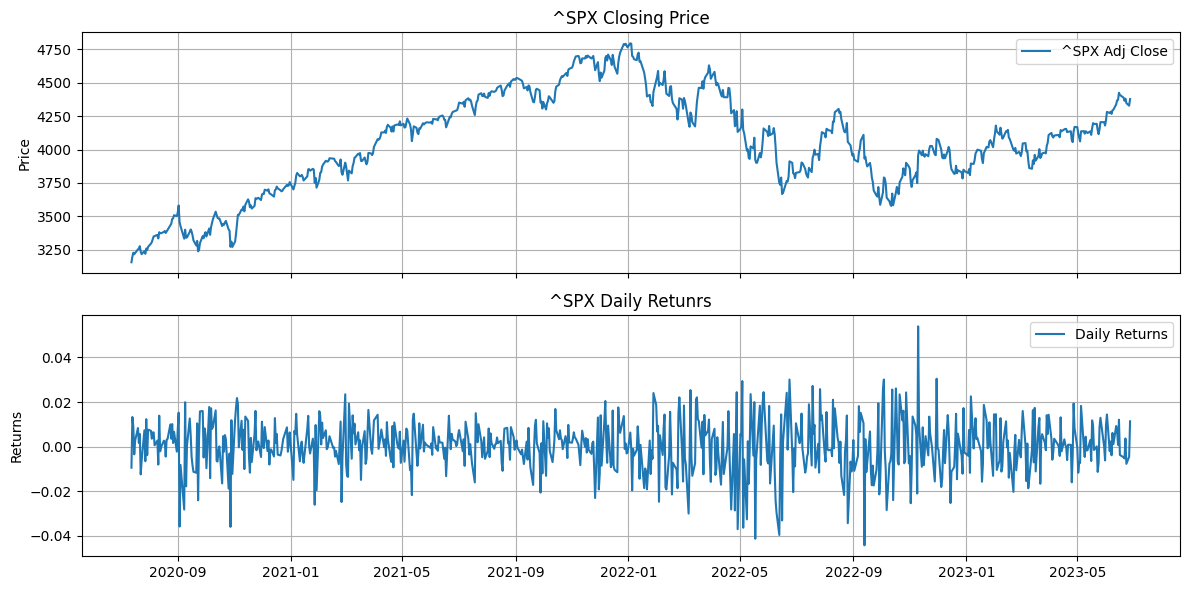

In [77]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();

In [78]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2020-07-09 00:00:00+00:00    0.000000
2020-07-10 00:00:00+00:00   -0.010232
Name: Strategy, dtype: float64

In [79]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'SPX'
benchmark_rets.head(2)

Date
2020-07-13 00:00:00+00:00   -0.009407
2020-07-14 00:00:00+00:00    0.013317
Name: SPX, dtype: float64

In [80]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-07-09
End date,2023-06-29
Total months,35
,Backtest
Annual return,11.456%
Cumulative returns,38.037%
Annual volatility,17.653%
Sharpe ratio,0.70
Calmar ratio,0.41
Stability,0.07
Max drawdown,-27.614%


/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/var/folders/xy/43_54dcn2r7dyrj61jc8jfch0000gn/T/ipykernel_69767/3790289085.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


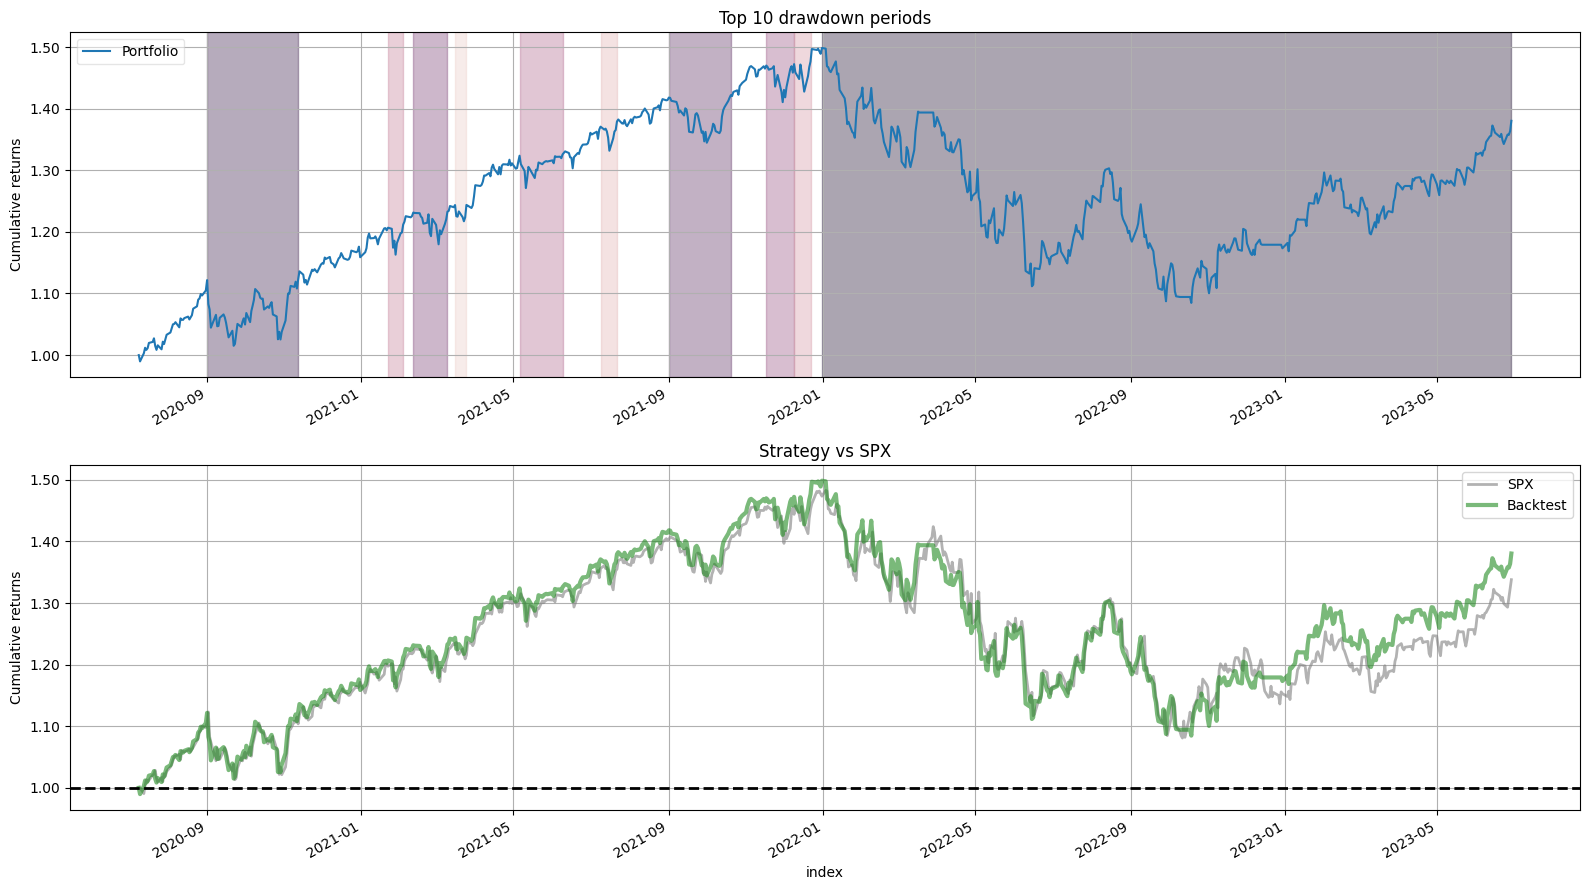

In [89]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 9), constrained_layout=True)

pf.plot_drawdown_periods(returns=returns, ax=ax[0])
ax[0].grid(True)

# Forward fill missing dates in factor_returns
ffilled_factor_returns = benchmark_rets.reindex(returns.index, method='ffill')

pf.plot_rolling_returns(returns=returns,
                        factor_returns=ffilled_factor_returns,
                        ax=ax[1], title='Strategy vs SPX')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()  # Ensure that the plot is shown


/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)
/Users/johanthomas/.pyenv/versions/3.10.6/envs/tothemoon/lib/python3.10/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)
/var/folders/xy/43_54dcn2r7dyrj61jc8jfch0000gn/T/ipykernel_69767/2743284008.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


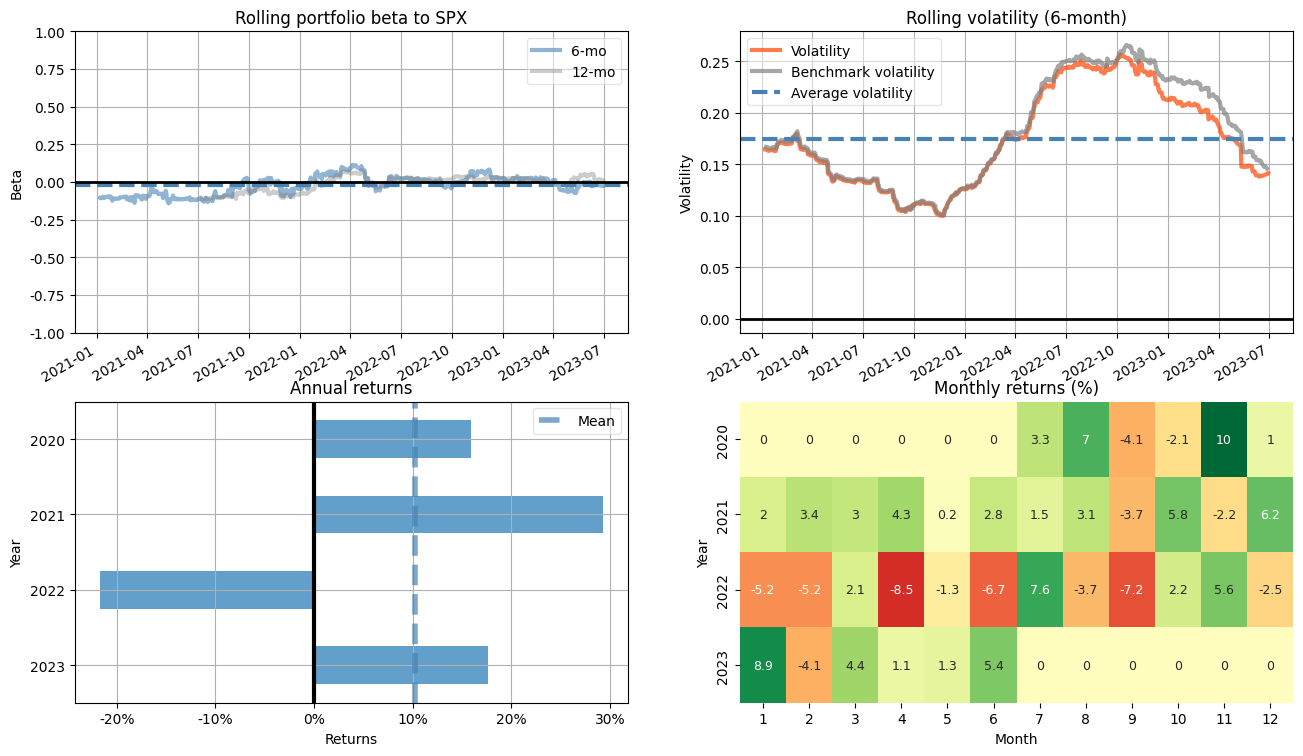

In [ ]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('BL Portfolio vs BSE-SENSEX - 2', fontsize=16, y=1.0)


plt.tight_layout()